## _PandaML_
- Perform detailed _Exploratory Data Analysis_ (EDA) on STT Data.

In [ ]:
import sys, os, glob, yaml

In [2]:
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trackml.dataset
import seaborn as sns

In [4]:
sys.path.append('src')

### _Dataset_

In [5]:
# mu- data (current)
#input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (coming)
input_dir = './data_sets/pandaml/data_0.1_1.5_GeV/'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [6]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [7]:
file_prefixes[:10]

['./data_sets/pandaml/data_0.1_1.5_GeV/event0000000000',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000001',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000002',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000003',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000004',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000005',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000006',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000007',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000008',
 './data_sets/pandaml/data_0.1_1.5_GeV/event0000000009']

In [8]:
event_id = 1
event_prefix = file_prefixes[event_id]

In [9]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.03 MB


In [10]:
# preprocess hits
# hits['r'] = hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
hits = hits.assign(r=hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1))
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,r
0,1,-12.2456,12.120,35.0,9,0,12,17.229310
1,2,-13.1203,12.625,35.0,9,1,117,18.208045
2,3,-13.9950,13.130,35.0,9,2,228,19.190021
3,4,-13.9950,14.140,35.0,9,3,344,19.894714
4,5,-14.8697,14.645,35.0,9,4,467,20.870650


In [11]:
# unique layer_id's
l_ids = np.unique(hits.layer_id.values)
print(l_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [12]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.262386,6000300.0,6.00030,9,0,12,0,0
1,2,0.052152,13722100.0,13.72210,9,1,117,0,0
2,3,0.374347,4073350.0,4.07335,9,2,228,0,0
3,4,0.265922,6590940.0,6.59094,9,3,344,0,0
4,5,0.085074,11615800.0,11.61580,9,4,467,0,0


In [13]:
# preprocess particles (I've duplicates: so drop duplicates, sort and reset_index) 
particles.drop_duplicates(inplace=True)
particles = particles.sort_values(by=['particle_id']).reset_index(drop=True)
particles.head(10)

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,-0.134669,0.028540,-0.091022,1,26,13,0
1,2,0.0,0.0,0.0,-0.550762,-0.441498,0.780609,1,26,13,0
2,3,0.0,0.0,0.0,-0.072724,0.023378,0.175138,1,26,13,0
3,4,0.0,0.0,0.0,0.936311,-0.311491,-1.019850,1,26,13,0
4,5,0.0,0.0,0.0,-1.049040,-0.440627,0.471787,1,26,13,0
5,6,0.0,0.0,0.0,0.097679,0.809758,0.673764,-1,26,-13,0
6,7,0.0,0.0,0.0,-0.583187,0.230254,0.850420,-1,26,-13,0
7,8,0.0,0.0,0.0,-0.527632,-0.436476,-0.400419,-1,26,-13,0
8,9,0.0,0.0,0.0,0.259037,0.056858,-0.217065,-1,26,-13,0
9,10,0.0,0.0,0.0,-0.246557,0.201217,0.335313,-1,26,-13,0


In [14]:
# unique particle_id's
p_ids = np.unique(particles.particle_id.values)
print(p_ids)

[ 1  2  3  4  5  6  7  8  9 10]


In [15]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-12.4533,11.9370,18.0376,-0.208362,0.236490,0.330727,1.0,10
1,2,-13.0823,12.6579,19.0411,-0.206470,0.238251,0.330621,1.0,10
2,3,-13.7024,13.3791,20.0387,-0.204324,0.239940,0.330703,1.0,10
3,4,-14.1996,13.9682,20.8477,-0.202521,0.241390,0.330725,1.0,10
4,5,-14.8052,14.6980,21.8424,-0.200172,0.243415,0.330639,1.0,10


### _Detector Layout_

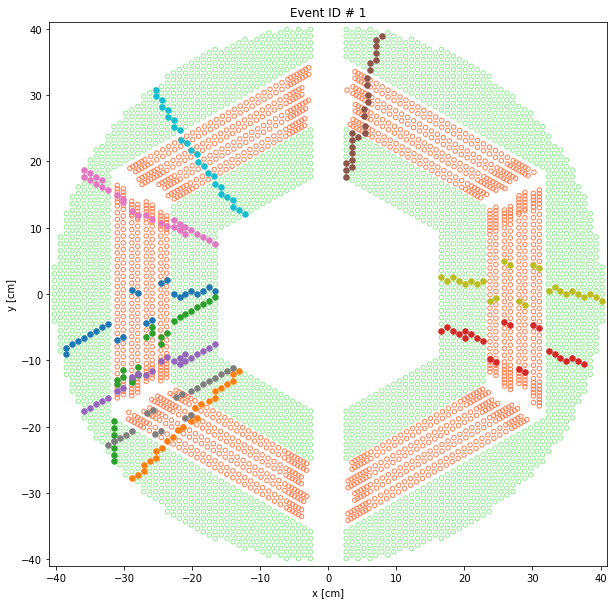

In [16]:
p_ids = np.unique(particles.particle_id.values)
det = pd.read_csv("src/stt.csv")
# plt.style.use('seaborn')
# fig = plt.gcf()
fig = plt.figure(figsize=(10,10))
skw = det.query('skewed==0')
nkw = det.query('skewed==1')
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')
for i in p_ids:
    df_ = hits.loc[truth.particle_id == i]
    plt.scatter(df_.x.values, df_.y.values, s=30, label='particle_id: %d' % i)
plt.title('Event ID # %d' % event_id)
plt.xlabel('x [cm]', fontsize=10)
plt.ylabel('y [cm]', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim((-41, 41))
plt.ylim((-41, 41))
plt.show()

### _Draw Tracks_

In [17]:
# we already have r - sorted hits, lets draw a single track.
data = hits[truth['particle_id'] == 5]

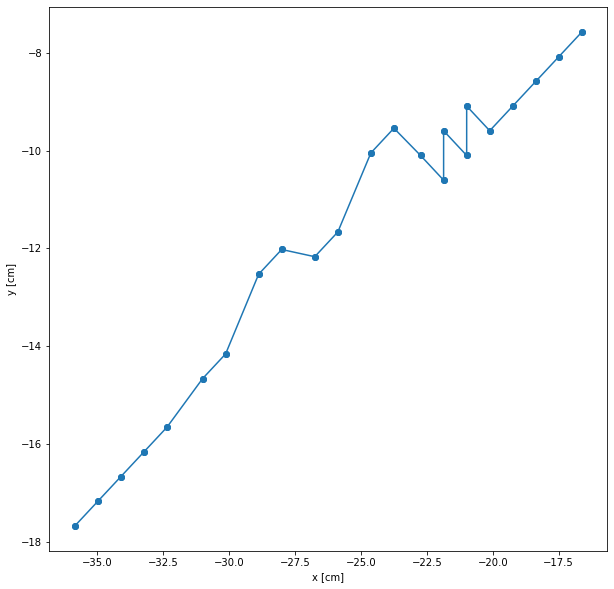

In [18]:
# Using Object Oriented API
plt.close('all')
plt.figure(figsize=(10,10))
plt.scatter(data.x.values, data.y.values)
plt.plot(data.x.values, data.y.values, "-o")
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
# ax.set_xlim(5, 40)
# ax.set_ylim(5, 40)
# plt.savefig(os.path.join(outdir, "event.png"))
plt.show()

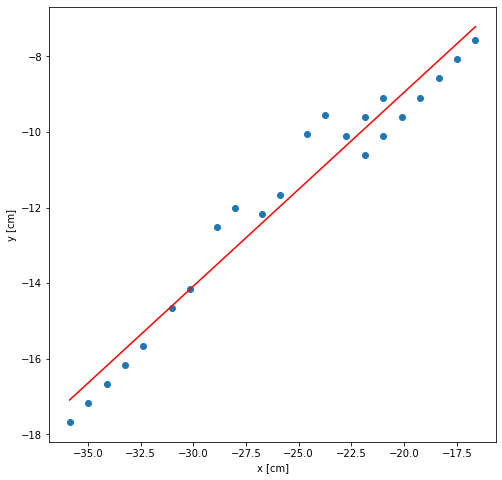

In [19]:
# numpy.polyfit() function
plt.close('all')
plt.figure(figsize=(8,8))

a, b = np.polyfit(data.x, data.y, 1)

plt.scatter(data.x.values, data.y.values)
plt.plot(data.x.values, a*data.x.values+b, 'r')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
#plt.xlim((5, 40))
#plt.ylim((5, 40))
plt.show()

### _Momentum Distributions_

In [20]:
# calculate pt
particles = particles.assign(pt=particles.apply(lambda row: np.sqrt(row.px**2 + row.py**2), axis=1))

In [21]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,pt
0,1,0.0,0.0,0.0,-0.134669,0.028540,-0.091022,1,26,13,0,0.137660
1,2,0.0,0.0,0.0,-0.550762,-0.441498,0.780609,1,26,13,0,0.705875
2,3,0.0,0.0,0.0,-0.072724,0.023378,0.175138,1,26,13,0,0.076389
3,4,0.0,0.0,0.0,0.936311,-0.311491,-1.019850,1,26,13,0,0.986765
4,5,0.0,0.0,0.0,-1.049040,-0.440627,0.471787,1,26,13,0,1.137821


In [22]:
particles.pt

0    0.137660
1    0.705875
2    0.076389
3    0.986765
4    1.137821
5    0.815628
6    0.626996
7    0.684768
8    0.265204
9    0.318243
Name: pt, dtype: float64

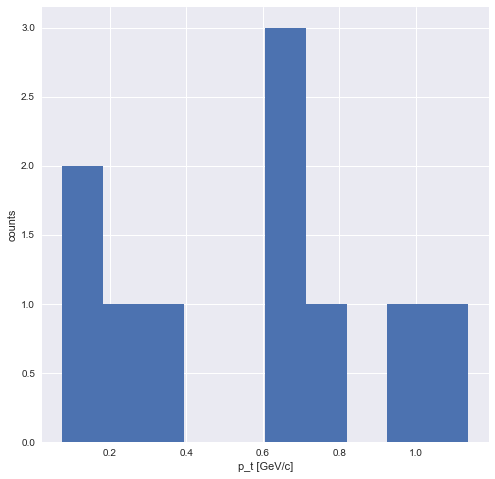

In [30]:
plt.close('all')
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))

plt.hist(particles.pt, bins=10)

plt.xlabel('p_t [GeV/c]')
plt.ylabel('counts')
# plt.xlim((0.1, 1.5))
#plt.ylim((5, 40))
plt.show()

In [24]:
# _ = particles[['px','py','pt']].hist(figsize = (8,8))

In [25]:
# Number of unique particles
len(truth.particle_id.unique())

10

In [26]:
# lets get unique pids with freq (~ hits).
sel_pids, sel_pids_fr = np.unique(particles.particle_id, return_counts=True)
sel_pids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [27]:
print("Average number of hits per tracks: {}".format(hits.hit_id.count()/sel_pids.size))

Average number of hits per tracks: 25.2
